# Pin Bar Reversal - Strategy - Backtesting 

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

/home/zuongthao/PycharmProjects/algo-stock/venv/lib/python3.11/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [6]:
def is_pin_bar(row):
    body = abs(row["Close"] - row["Open"])
    upper_wick = row["High"] - max(row["Close"], row["Open"])
    lower_wick = min(row["Close"], row["Open"]) - row["Low"]
    return (lower_wick > 1.7 > 2 * body) or (upper_wick > 1.7 > 2 * body)

In [7]:
def cal_signal(r):
    signal = ''
    if r['PinBar']:
        if r['Low'] == r['min_15']:
            signal = 'long'
        elif ['High'] == r['max_15']:
            signal = 'short'
    return signal    

In [8]:
def prepare_data(df):
    df["PinBar"] = df.apply(is_pin_bar, axis=1)
    df['max_15'] = df['High'].rolling(15).min()
    df['min_15'] = df['Low'].rolling(10).min()
    df['signal'] = df.apply(lambda r: cal_signal(r), axis=1)
    return df

In [9]:
# ChatGPT
# Strategy Logic:
# 1.Identify Pin Bars:
# 	A Pin Bar is detected if either:
# 	The lower wick is at least twice the size of the body (bullish Pin Bar).
# 	The upper wick is at least twice the size of the body (bearish Pin Bar).
# 2. Trade Setup:
# 	Buy Entry (Bullish Reversal):
# 	The detected Pin Bar’s low is the lowest low in the last 5 candles (suggesting support).
# 	Stop Loss (SL) is set below the Pin Bar’s low minus max_sl.
# 	Take Profit (TP) is set using a 2:1 risk-reward ratio.
# 	Sell Entry (Bearish Reversal):

# 	The detected Pin Bar’s high is the highest high in the last 5 candles (suggesting resistance).
# 	Stop Loss (SL) is set above the Pin Bar’s high plus max_sl.
# 	Take Profit (TP) is set using a 2:1 risk-reward ratio.

In [20]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [22]:
prepared_data[prepared_data.signal != '']

,Open,High,Low,Close,Volume,PinBar,max_15,min_15,signal
Date,,,,,,,,,
2020-11-05 13:30:00,916.2,916.7,914.4,916.5,5062,True,916.5,914.4,long
2020-11-16 13:50:00,929.0,929.4,925.5,928.2,5747,True,925.4,925.5,long
2020-11-16 14:10:00,929.0,929.0,923.5,928.7,8235,True,929.0,923.5,long
2020-11-16 14:25:00,917.1,920.5,916.0,917.6,9783,True,920.5,916.0,long
2020-11-18 13:20:00,932.2,932.3,930.1,931.9,5887,True,932.3,930.1,long
...,...,...,...,...,...,...,...,...,...
2025-01-10 11:20:00,1311.3,1311.3,1309.0,1311.1,6568,True,1311.3,1309.0,long
2025-01-10 13:30:00,1307.6,1308.1,1305.6,1307.6,6362,True,1307.8,1305.6,long
2025-01-13 09:00:00,1287.6,1290.2,1286.3,1288.3,7350,True,1290.2,1286.3,long


In [49]:
prepared_data[prepared_data.index == '2025-01-21 09:15:00']

,Open,High,Low,Close,Volume,PinBar,max_15,min_15,signal
Date,,,,,,,,,
2025-01-21 09:15:00,1330.7,1332.3,1330.0,1330.3,4912,False,1322.0,1321.2,


In [42]:
class MainStrategy(Strategy):
    risk_reward_ratio = 2
    max_sl = 3.1
    close_deal_threshold = 0
  
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position:
                self.position.close()
            return
        #
        if self.position:
            # entry_price = self.trades[0].entry_price
            if self.position.is_long and self.data.Close[-1] < self.close_deal_threshold:
                self.position.close()
                self.close_deal_threshold = 0
            elif self.position.is_short and self.data.Close[-1] > self.close_deal_threshold:
                self.position.close()
                self.close_deal_threshold = 0
            return
        #
        signal = self.data.signal[-1]
        open_price = self.data.Open[-1]
        close_price = self.data.Close[-1]
        if signal == 'long':
            sl = close_price - self.max_sl
            tp = close_price + self.max_sl * self.risk_reward_ratio
            self.buy(size=1, sl=sl, tp=tp)
            self.close_deal_threshold = open_price
        elif signal == 'short':
            sl = close_price + self.max_sl
            tp = close_price - self.max_sl * self.risk_reward_ratio
            self.sell(size=1, sl=sl, tp=tp)
            self.close_deal_threshold = open_price

In [43]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [44]:
stats

Start                     2020-11-02 13:55:00
End                       2025-02-13 14:45:00
Duration                   1564 days 00:50:00
Exposure Time [%]                    2.369965
Equity Final [$]                   1366.67356
Equity Peak [$]                    1504.44665
Return [%]                          -8.888429
Buy & Hold Return [%]               48.281596
Return (Ann.) [%]                   -2.172451
Volatility (Ann.) [%]                1.844537
Sharpe Ratio                        -1.177776
Sortino Ratio                       -1.643916
Calmar Ratio                         -0.19634
Max. Drawdown [%]                  -11.064759
Avg. Drawdown [%]                   -5.551543
Max. Drawdown Duration     1550 days 00:50:00
Avg. Drawdown Duration      780 days 12:38:00
# Trades                                  347
Win Rate [%]                        24.495677
Best Trade [%]                        0.69849
Worst Trade [%]                     -0.692557
Avg. Trade [%]                    

In [46]:
stats['_trades'].tail(15)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
332,1,50542,50562,1347.10401,1353.0,5.89599,0.004377,2024-10-23 10:40:00,2024-10-23 13:45:00,None,0 days 03:05:00
333,1,50921,50922,1335.10041,1333.2,-1.90041,-0.001423,2024-11-01 13:55:00,2024-11-01 14:00:00,None,0 days 00:05:00
334,1,50969,50979,1319.39570,1320.0,0.60430,0.000458,2024-11-04 13:40:00,2024-11-04 14:30:00,None,0 days 00:50:00
335,1,51181,51182,1320.89615,1321.0,0.10385,0.000079,2024-11-08 14:20:00,2024-11-08 14:25:00,None,0 days 00:05:00
336,1,52045,52050,1314.39420,1313.2,-1.19420,-0.000909,2024-12-03 14:05:00,2024-12-03 14:30:00,None,0 days 00:25:00
337,1,53083,53087,1339.20164,1337.9,-1.30164,-0.000972,2025-01-02 10:40:00,2025-01-02 11:00:00,None,0 days 00:20:00
338,1,53141,53142,1333.19984,1332.2,-0.99984,-0.000750,2025-01-03 11:15:00,2025-01-03 11:20:00,None,0 days 00:05:00
339,1,53213,53214,1321.89645,1321.2,-0.69645,-0.000527,2025-01-06 14:25:00,2025-01-06 14:30:00,None,0 days 00:05:00
340,1,53359,53360,1315.79462,1314.7,-1.09462,-0.000832,2025-01-09 13:50:00,2025-01-09 13:55:00,None,0 days 00:05:00
341,1,53363,53367,1312.79372,1311.9,-0.89372,-0.000681,2025-01-09 14:10:00,2025-01-09 14:30:00,None,0 days 00:20:00


In [47]:
# bt.plot()

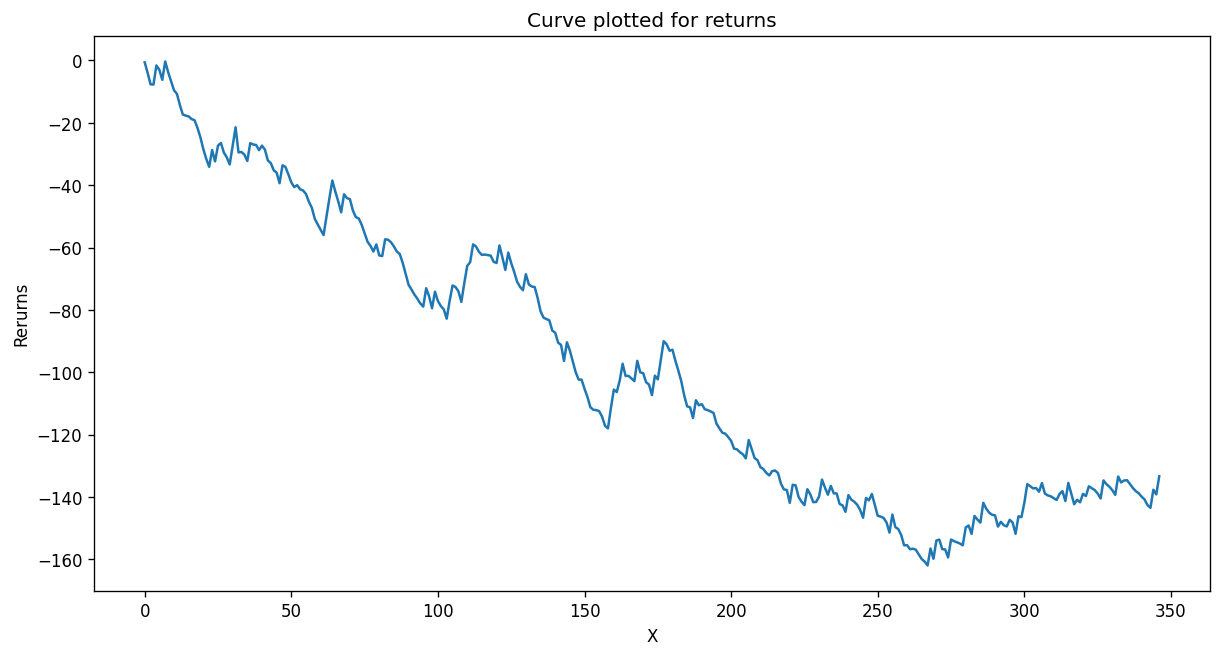

In [48]:
trades = stats['_trades']
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()